In [1]:
import numpy as np
import math
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.special import gamma, factorial
from scipy.stats import beta
import time

In [2]:
class PowerDiagram1D:
    def __init__(self, X, weights=None, L=1.0):
        """
        Parameters
        ----------
        X : ndarray,
            positions of particles (assumed ordered with no repeats)
        weights : ndarray, optional,
            weights of Laguerre cells
        L : float, optional,
            domain length
        """
        # use deep copy to make it independent, trivially slower, same for following copies
        self.X = np.array(X, copy=True)
        # store len(X) to avoid repeated reading
        self.n = len(X) 
        # check None in int to avoid checking everytime calling update_boundaries
        self.weights = np.zeros(self.n) if weights is None else np.array(weights, copy=True) 
        self.L = L
        self.Bounds = np.empty(self.n)
        self.indices = []
        self.updated_flag = False

    def set_positions(self, X):
        self.X = np.array(X, copy=True)

    def set_weights(self, weights):
        self.weights = np.array(weights, copy=True)
        self.updated_flag = False

    def update_boundaries(self):
        """
        Compute power diagram boundaries via Graham scan.
        """
        indices = [0, 1]
        u = (self.X**2 - self.weights) / 2

        # same function, but more readable and easier to debug
        def slope(i, j):
            return (u[j] - u[i]) / (self.X[j] - self.X[i])

        # same thing, but simpler, cleaner
        for i in range(2, self.n):
            while len(indices) >= 2 and slope(i, indices[-1]) <= slope(indices[-1], indices[-2]):
                indices.pop()
            indices.append(i)

        Bounds_noconstr = (u[indices][1:] - u[indices][:-1]) / (self.X[indices][1:] - self.X[indices][:-1])

        # Just not use mask (I do not get the point of creating mask here).
        i0 = np.sum(Bounds_noconstr <= 0)
        iend = np.sum(Bounds_noconstr >= self.L)
        indices = indices[i0:len(indices) - iend]

        self.indices = indices
        self.Bounds = np.zeros(len(indices) + 1)
        self.Bounds[-1] = self.L
        self.Bounds[1:-1] = Bounds_noconstr[i0:len(Bounds_noconstr) - iend] #(u[indices][1:] -u[indices][:-1])/(self.X[indices][1:] - self.X[indices][:-1])

        self.updated_flag = True

    def compute_energy(self, fun=None):
        """
        Computes power diagram energy sum_i int_{L_i} |x-x_i|^2
        """
        fplus = (self.Bounds[1:] - self.X[self.indices])**3/3
        fminus = (self.Bounds[:-1] - self.X[self.indices])**3/3
        return np.sum(fplus - fminus) # return directly

    def compute_integrals(self, fun):
        """
        Compute integral of function rho over Laguerre cells.
        Parameters:
        ----------
        fun: function. Density to integrate
        """
        if not self.updated_flag:
            self.update_boundaries()
        N = len(self.Bounds) - 1
        integrals = np.zeros(N)
        for i in range(N):
            integrals[i], _ = quad(fun, self.Bounds[i], self.Bounds[i + 1])
        return integrals

    def compute_integrals_ipp(self, intp_fun, p=None):
        """
        Computes the integral of fun(x)*(x-x_i)^p over Laguerre cells using integration by parts.
        Parameters:
        ----------
        intp_rho : list of length p+1, of lambda functions providing [int fun, int int fun , ..]
        """
        if p is None:
            p = len(intp_fun)-1
        else:
            assert len(intp_fun)>=p+1

        if p == 0:
            return intp_fun[0](self.Bounds[1:])-intp_fun[0](self.Bounds[:-1])
        # No need for else here
        integrals_p = ((self.Bounds[1:] - self.X[self.indices])**p*intp_fun[0](self.Bounds[1:])
                       - (self.Bounds[:-1] - self.X[self.indices])**p*intp_fun[0](self.Bounds[:-1]))
        integrals = -p * self.compute_integrals_ipp(intp_fun[1:], p=p-1) + integrals_p
        return integrals

    def compute_integrals_gradient(self, fun):
        """
        Compute gradient with respect to weights of 
            G: w --> integrals of function rho over Laguerre cells.
        """
        if not self.updated_flag:
            self.update_boundaries()
        # Force lower bound on density
        # temporary use, copy unnecessary
        Xact = self.X[self.indices]
        feval = fun(self.Bounds[1:-1])
        # fmin = np.min(feval) # unused object
        feval = feval * (1 - 1e-2) + 1e-2 #- fmin +   np.max((1e-2,fmin))
        
        #(np.maximum(fun(self.Bounds[1:-1])-fmin,0)+fmin)
        vect = 0.5 * feval/np.abs(Xact[1:] - Xact[:-1])
        vect0 = vect.copy()
        vect0[0] = 0
        costhess = diags(vect, -1) + diags(vect0, 1)
        vect1 = np.array(costhess.sum(axis=1)).flatten()

        # First row is zero apart from first element
        vect1[0] = -1
        costhess -= diags(vect1)

        return -costhess

In [3]:
class OptimalTransport1D(PowerDiagram1D):
    def __init__(self, X, masses, rho, intp_rho=None, L=1.0):
        super().__init__(X, L=L)
        self.masses = np.array(masses, copy=True)
        self.rho = rho
        self.intp_rho = intp_rho  # list of integrals of rho
        
    def compute_ot_cost(self):
        """
        Compute the optimal transport cost using direct quadrature.
        """
        N = len(self.Bounds) - 1
        integrals = np.zeros(N)
        for i in range(N):
            fun = lambda x: ((x - self.X[self.indices][i])**2 - self.weights[self.indices][i]) * self.rho(x)
            integrals[i], _ = quad(fun, self.Bounds[i], self.Bounds[i + 1]) # same, more readable
        return np.sum(integrals) + np.sum(self.masses * self.weights)

    def compute_ot_cost_ipp(self):
        """
        Compute the optimal transport cost using integration by parts.
        """
        # Modified to make it cleaner, more readable, and easier to debug
        term1 = np.sum(self.compute_integrals_ipp(self.intp_rho, p=2))
        term2 = np.sum(self.compute_integrals_ipp(self.intp_rho, p=0) * self.weights[self.indices])
        return np.sum(self.masses * self.weights) + (term1 - term2)

    def update_weights(self, tol=1e-6, maxIter=5e2, verbose=False):
        """
        Computes optimal weights with damped Newton
        """
        # Armijo parameter
        alphaA = 0.01
        tau_init = 0.5
        # New maximum number of update_boundaries() per step; used in the linesearch later
        max_line_search_trials = 3 
    
        self.update_boundaries()
    
        F = -self.masses.copy()
        if self.intp_rho is None:
            F[self.indices] += self.compute_integrals(self.rho)
            cost_old = self.compute_ot_cost()
        else:
            F[self.indices] += self.compute_integrals_ipp(self.intp_rho, p=0)
            cost_old = self.compute_ot_cost_ipp()
    
        error = np.linalg.norm(F)
        i = 0
    
        while error > tol and i < maxIter:
            Hess = self.compute_integrals_gradient(self.rho)
    
            theta = 0.0
            deltaw = -theta * F
            deltaw[self.indices] -= (1 - theta) * spsolve(Hess, F[self.indices])
    
            weights_old = self.weights.copy()
            tau = tau_init
            trial = 0
    
            """
            Smarter line search:
            Do not call update_boundaries() endlessly (3 times max), 
            where update_boundaries() has complexity of O(n)
            """
            while trial < max_line_search_trials:
                self.weights = weights_old + tau * deltaw
                self.update_boundaries()
    
                if self.intp_rho is None:
                    cost = self.compute_ot_cost()
                else:
                    cost = self.compute_ot_cost_ipp()
    
                # Armijo condition
                if (cost >= cost_old + tau * alphaA * np.dot(F, deltaw)
                        and len(self.indices) == len(self.X)):
                    break
                else:
                    tau *= 0.8
                    trial += 1
    
            # (If after 3 trials we still haven't satisfied Armijo, accept the last tau anyway)
    
            cost_old = cost
            i += 1
    
            # Update F and error
            F = -self.masses.copy()
            if self.intp_rho is None:
                F[self.indices] += self.compute_integrals(self.rho)
            else:
                F[self.indices] += self.compute_integrals_ipp(self.intp_rho, p=0)
    
            error = np.linalg.norm(F)
    
            if verbose:
                print(f"Newton step {i}, cost: {cost:.6f}, tau: {tau:.2e}, error: {error:.2e}")
    
            tau_init = min(tau * 1.1, 1.0)
    
        if i < maxIter and verbose:
            print("Optimization success!")

In [4]:
# Number of main signal samples
N = 300

# set seed for both the original version and this version to compare time cost
np.random.seed(0)

# Main signal: Beta(2, 2)
sig = np.random.beta(2, 2, size=N - 12)

# Contaminations: 7 samples from each
noi1 = np.random.beta(1, 100, size=6)
noi2 = np.random.beta(100, 1, size=6)

# Combine and sort
X = np.sort(np.concatenate([sig, noi1, noi2]))

# Convert to array (already is)
X = np.array(X)

In [5]:
np.where(np.arange(10) > 0)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [6]:
start_time = time.time()

In [7]:
L = 1.
masses = np.ones(N) / N

## Centering distribution is Beta(2,2)
rho0 = lambda x: 6*x*(1-x)

mass = 1.
masses = masses*mass

eta = 1e-3 # learning rate
n = len(X)
maxiter = 3000

## Run the fixed point iteration 80 times
for i in range(maxiter): 
    # solve optimal transport
    ot = OptimalTransport1D(X,masses,rho0, L=L)
    ot.update_weights(maxIter=1,verbose =False)
    ww=ot.weights

    # update masses
    masses1 = masses + eta*(-1-np.log(n*masses) - 2*5*ww)

    # projection back to simplex
    temp = np.max(np.where((masses1 + 1/(np.arange(1, len(masses1) + 1))*(1 - np.cumsum(masses1)) > 0))) + 1
    right_shift = (1/temp)*(1-np.cumsum(masses1)[temp-1])
    masses1 = masses1 + right_shift
    masses1[masses1 < 0] = 0

    # convergence check
    err = np.sum((masses-masses1)**2)
    if err <= 1e-20: 
      break
        
    ## print iteration
    print(i)
    ## track error
    print(err)
    masses = masses1

0
7.725074797669574e-08
1
3.3010947188537864e-08
2
1.4075460004611942e-08
3
5.997644455523054e-09
4
2.556454692051637e-09
5
1.090651863932066e-09
6
4.658645472258692e-10
7
1.9926048554842383e-10
8
8.534774452523664e-11
9
3.6607736554691107e-11
10
1.5723761954976086e-11
11
6.762939030830923e-12
12
2.9127743535583452e-12
13
1.2562440519206548e-12
14
5.425602271811591e-13
15
2.346644683843163e-13
16
1.016478931649052e-13
17
4.409957427290219e-14
18
1.9164398850181387e-14
19
8.343081173000289e-15
20
3.6389745714265966e-15
21
1.590406166429659e-15
22
6.96582083722848e-16
23
3.0579695477513107e-16
24
1.3457168096647218e-16
25
5.937416740736964e-17
26
2.626805216109685e-17
27
1.1654834591080706e-17
28
5.186695166316158e-18
29
2.315452841261426e-18
30
1.037028161971183e-18
31
4.660115945202849e-19
32
2.1013044449850968e-19
33
9.508090384030405e-20
34
4.317441165748375e-20
35
1.9674127413066588e-20


In [8]:
# check final error for comparison
print(f"Final error after loop: {err:.2e}")

Final error after loop: 9.00e-21


In [9]:
end_time = time.time()
print(f"Time cost: {end_time - start_time:.6f} seconds")
# usually 70~90 seconds

Time cost: 15.530689 seconds


In [10]:
x=ot.weights

Text(0.5, 1.0, 'Histogram of Original Data')

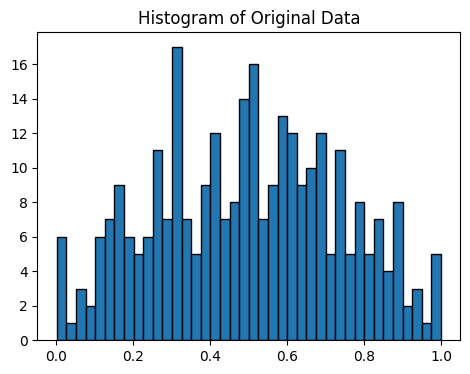

In [11]:
# Assuming X and masses1 (updated weights) are already defined
N = len(X)

# 1. Histogram of original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(X, bins=40, edgecolor='black')
plt.title("Histogram of Original Data")

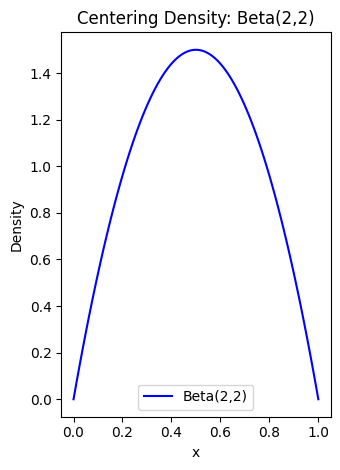

In [12]:
# 2. Plot centering density Beta(2, 2)
grid = np.linspace(0, 1, 100)
plt.subplot(1, 2, 2)
plt.plot(grid, beta.pdf(grid, 2, 2), label='Beta(2,2)', color='blue')
plt.title("Centering Density: Beta(2,2)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

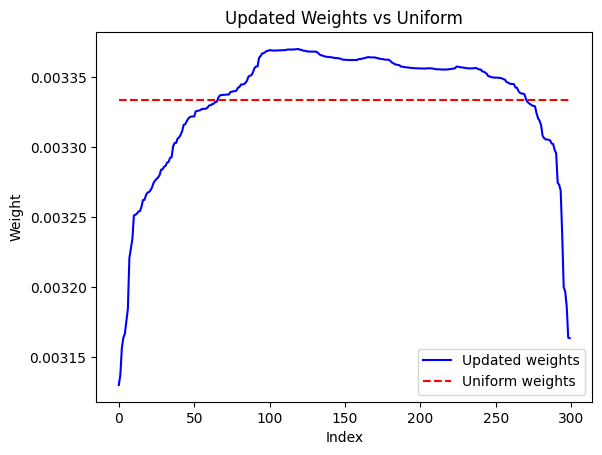

In [13]:
# 3. Plot updated weights vs uniform weights
plt.figure()
plt.plot(masses1, label='Updated weights', color='blue')
plt.plot(np.ones(N)/N, label='Uniform weights', color='red', linestyle='--')
plt.title("Updated Weights vs Uniform")
plt.xlabel("Index")
plt.ylabel("Weight")
plt.legend()
plt.show()

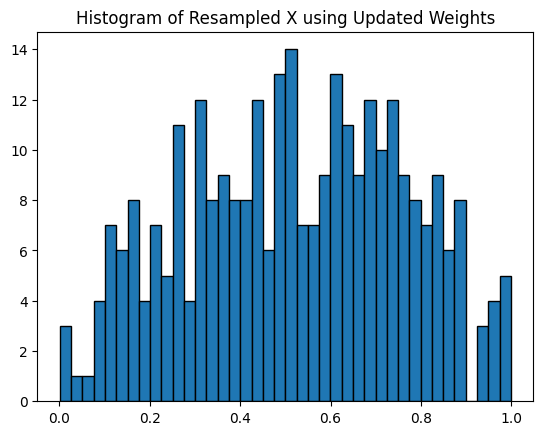

In [14]:
# 4. Resample X using updated weights
X_tilde = np.random.choice(X, size=N, p=masses1, replace=True)

# Plot histogram of resampled data
plt.hist(X_tilde, bins=40, edgecolor='black')
plt.title("Histogram of Resampled X using Updated Weights")
plt.show()